In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from os.path import join, basename
from glob import glob
import pickle
from scipy.stats import pearsonr
from scipy.signal import periodogram, filtfilt
import seaborn as sns

from filtering import freq_filt

In [2]:
banner_coords = (44.3, -115.233)
res = pd.read_csv('/bsuscratch/zacharykeskinen/data/infrasound/eq_catalog/selected_v2.csv')
from shapely import wkt
res['geometry'] = res['geometry'].apply(wkt.loads)
gdf = gpd.GeoDataFrame(res, geometry = 'geometry', crs = 'EPSG:4326')

data_dir = '/bsuscratch/zacharykeskinen/data/infrasound/array_data'
with open(join(data_dir, 'merged/all_days'), 'rb') as f:
    days = pickle.load(f)
sps = 200

In [8]:
result_dir = '/bsuscratch/zacharykeskinen/data/infrasound/psd_results'
corrs = {}
for fp in glob(join(result_dir, '*')):
    if '-' in fp:
        window = (basename(fp).split('.')[0].split('_')[-1])
        with open(fp, 'rb') as f:
            corrs[window] = pickle.load(f)

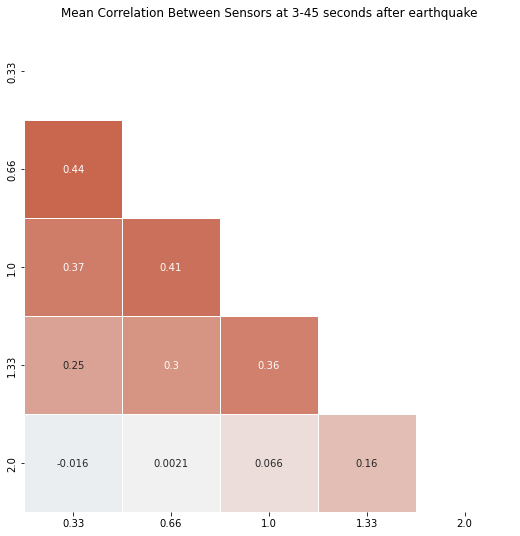

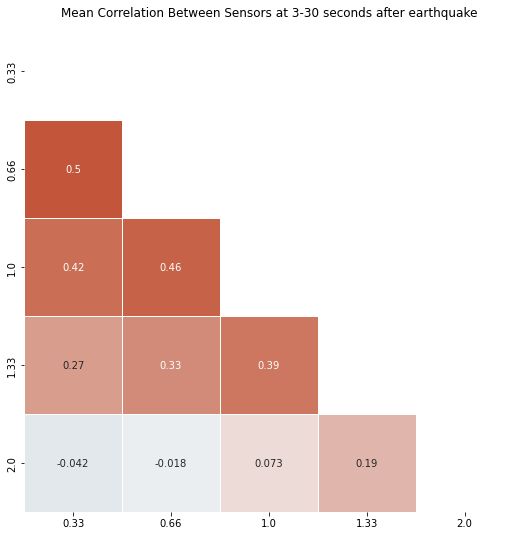

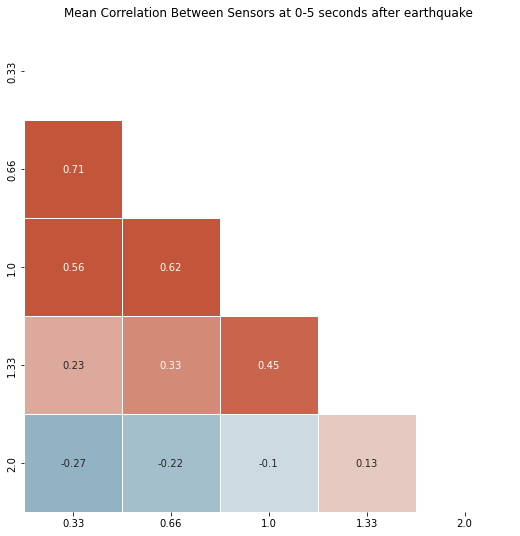

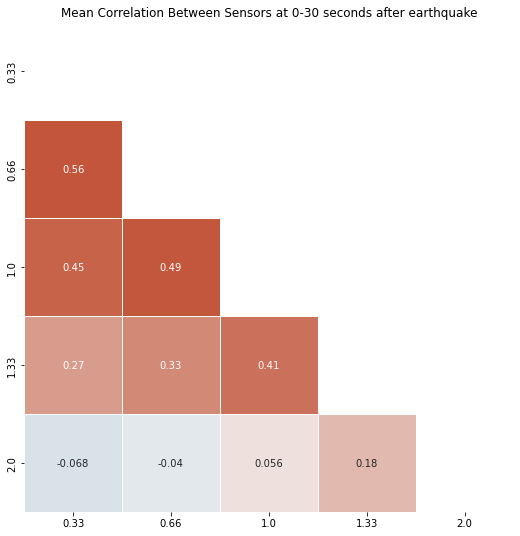

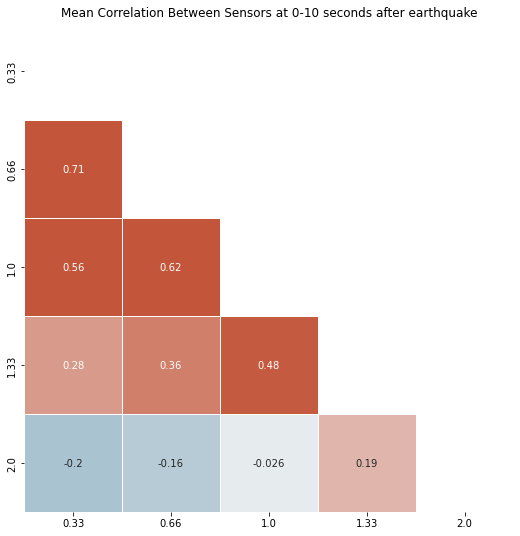

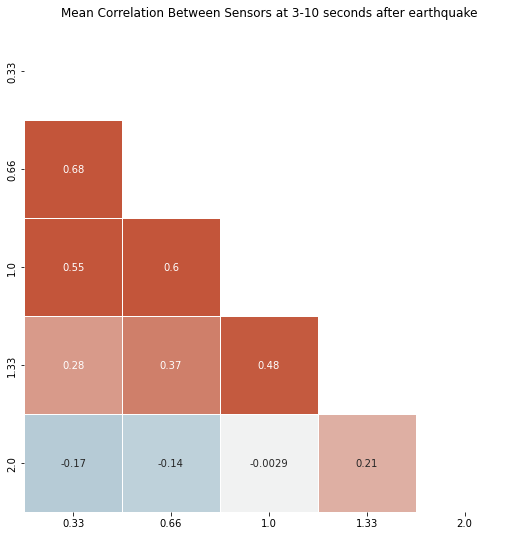

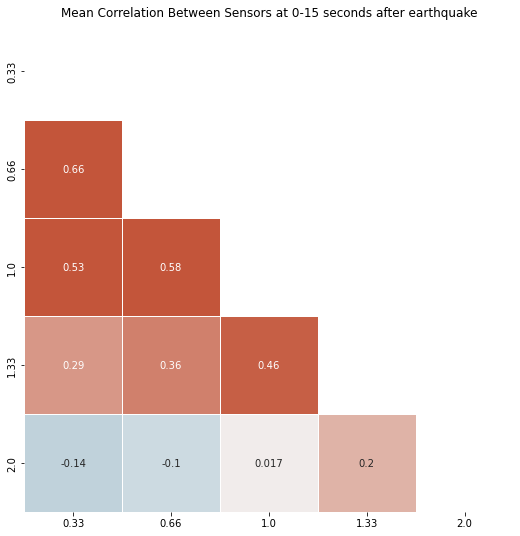

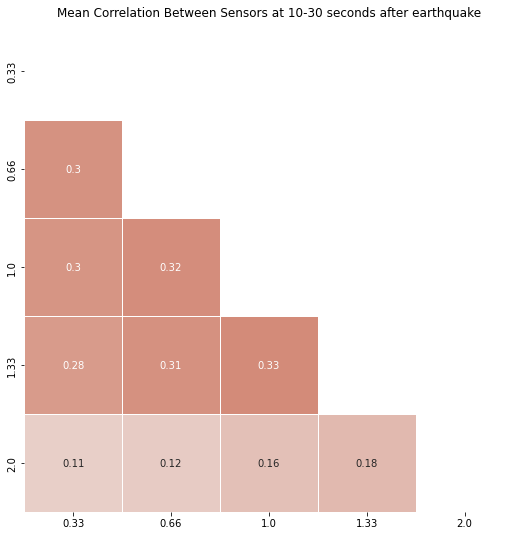

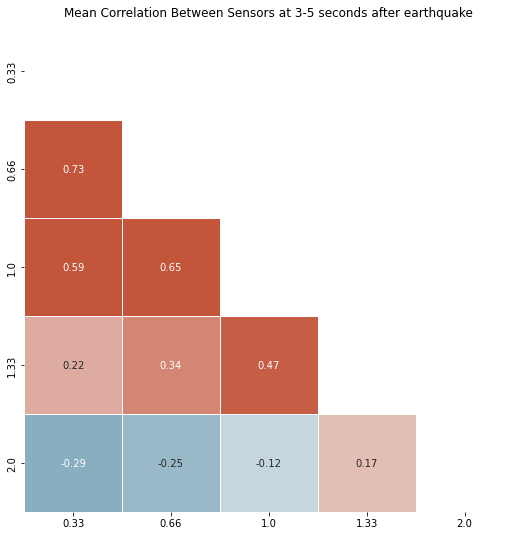

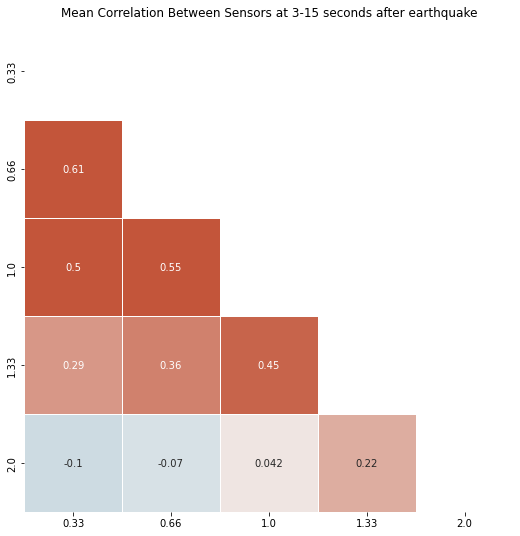

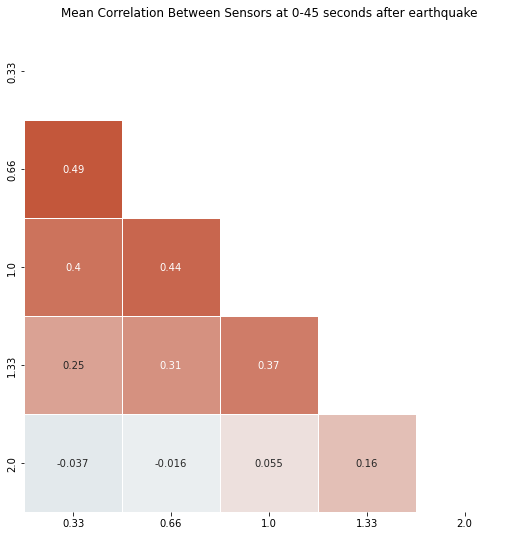

In [11]:
for window, corr in corrs.items():
    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.5, center=.0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot = True, cbar=False)
    plt.title(f'Mean Correlation Between Sensors at {window} seconds after earthquake')